# Notebook 01: CUDA Basics

## Introduction to GPU Programming

Welcome to your first CUDA programming tutorial! In this notebook, you'll learn:

1. **CUDA Execution Model** - Understanding threads, blocks, and grids
2. **Memory Hierarchy** - How data moves between CPU and GPU
3. **Your First Kernels** - Vector addition and matrix multiplication
4. **Performance Measurement** - Benchmarking GPU vs CPU

### Why CUDA?

Modern GPUs contain thousands of cores optimized for parallel computation. While CPUs excel at sequential tasks, GPUs can process massive amounts of data simultaneously - perfect for neural networks!

**Example:** A simple vector addition of 10 million elements:
- **CPU:** ~15ms (sequential processing)
- **GPU:** ~0.5ms (parallel processing)
- **Speedup:** ~30x faster! 🚀

In [1]:
# Import required libraries
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Tuple

# Check CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ CUDA not available. This notebook requires a GPU.")
    print("You can still learn the concepts, but won't see performance benefits.")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU Device: NVIDIA GeForce RTX 4070
GPU Memory: 12.88 GB


## Part 1: CUDA Execution Model

### The GPU Hierarchy

CUDA organizes parallel work into three levels:

```
Grid (Entire Computation)
  └── Blocks (Groups of Threads)
        └── Threads (Individual Workers)
```

**Key Concepts:**

1. **Thread:** The smallest unit of execution - does one piece of work
2. **Block:** A group of threads (up to 1024) that can cooperate and share memory
3. **Grid:** Collection of blocks that execute the same kernel function

**Example:** Adding two vectors of 10,000 elements
- Launch 10 blocks × 1000 threads = 10,000 threads
- Each thread adds one pair of elements
- All threads run simultaneously!

### Memory Spaces

```
┌─────────────────────────────────────────┐
│           Host (CPU)                     │
│  - Main RAM (large, slow to GPU)        │
└──────────────┬──────────────────────────┘
               │ PCIe Bus
┌──────────────▼──────────────────────────┐
│           Device (GPU)                   │
│  - Global Memory (large, slower)        │
│  - Shared Memory (small, fast)          │
│  - Registers (tiny, fastest)            │
└─────────────────────────────────────────┘
```

## Part 2: Vector Addition - Your First CUDA Kernel

Let's implement parallel vector addition: `C = A + B`

### CPU Version (Sequential)

In [5]:
import time

def vector_add_cpu(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Sequential CPU vector addition."""
    return a + b

# Test with small arrays
n = 10
a_cpu = np.random.randn(n).astype(np.float32)
b_cpu = np.random.randn(n).astype(np.float32)

start_time = time.perf_counter()
c_cpu = vector_add_cpu(a_cpu, b_cpu)
end_time = time.perf_counter()

elapsed_time = (end_time - start_time) * 1000  # Convert to milliseconds

print("CPU Vector Addition:")
print(f"A: {a_cpu[:5]}...")
print(f"B: {b_cpu[:5]}...")
print(f"C: {c_cpu[:5]}...")
print(f"Execution time: {elapsed_time:.4f} ms")

CPU Vector Addition:
A: [-1.019988    0.06357224  0.8349429  -1.9257647   1.990915  ]...
B: [-1.7675339   0.06672303 -0.17373934 -1.2132677   0.6181199 ]...
C: [-2.7875218   0.13029528  0.6612035  -3.1390324   2.6090348 ]...
Execution time: 0.0466 ms


### GPU Version (Parallel)

With PyTorch, we can leverage CUDA tensors for automatic GPU acceleration:

In [4]:
def vector_add_gpu(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """Parallel GPU vector addition using PyTorch CUDA tensors."""
    return a + b

# Create GPU tensors
if torch.cuda.is_available():
    # Transfer data to GPU
    a_gpu = torch.from_numpy(a_cpu).cuda()
    b_gpu = torch.from_numpy(b_cpu).cuda()
    
    # Perform addition on GPU
    start_time = time.perf_counter()
    c_gpu = vector_add_gpu(a_gpu, b_gpu)
    end_time = time.perf_counter()

    elapsed_time = (end_time - start_time) * 1000  # Convert to milliseconds
    
    # Transfer result back to CPU for verification
    c_gpu_cpu = c_gpu.cpu().numpy()
    
    print("\nGPU Vector Addition:")
    print(f"Result: {c_gpu_cpu[:5]}...")
    print(f"\nMatches CPU? {np.allclose(c_cpu, c_gpu_cpu)}")
    print(f"Execution time: {elapsed_time:.4f} ms")
else:
    print("GPU not available - skipping GPU test")


GPU Vector Addition:
Result: [ 2.4784522  0.5777215  2.3203533 -0.9345391 -1.9790201]...

Matches CPU? True
Execution time: 0.1065 ms


### Performance Comparison: CPU vs GPU

Let's benchmark with larger arrays to see real performance differences:

In [6]:
def benchmark_vector_add(sizes: list) -> Tuple[list, list]:
    """Benchmark vector addition at different sizes."""
    cpu_times = []
    gpu_times = []
    
    for size in sizes:
        # Create test data
        a = np.random.randn(size).astype(np.float32)
        b = np.random.randn(size).astype(np.float32)
        
        # CPU benchmark
        start = time.time()
        _ = a + b
        cpu_times.append((time.time() - start) * 1000)  # Convert to ms
        
        # GPU benchmark
        if torch.cuda.is_available():
            a_gpu = torch.from_numpy(a).cuda()
            b_gpu = torch.from_numpy(b).cuda()
            
            # Warm-up
            _ = a_gpu + b_gpu
            torch.cuda.synchronize()  # Wait for GPU to finish
            
            # Actual benchmark
            start = time.time()
            _ = a_gpu + b_gpu
            torch.cuda.synchronize()
            gpu_times.append((time.time() - start) * 1000)
        else:
            gpu_times.append(0)
    
    return cpu_times, gpu_times

# Run benchmarks
sizes = [10**3, 10**4, 10**5, 10**6, 10**7]
cpu_times, gpu_times = benchmark_vector_add(sizes)

# Display results
print("\nPerformance Benchmark Results:")
print("="*60)
print(f"{'Size':<12} {'CPU (ms)':<12} {'GPU (ms)':<12} {'Speedup':<12}")
print("="*60)

for size, cpu_t, gpu_t in zip(sizes, cpu_times, gpu_times):
    speedup = cpu_t / gpu_t if gpu_t > 0 else 0
    print(f"{size:<12} {cpu_t:<12.4f} {gpu_t:<12.4f} {speedup:<12.2f}x")


Performance Benchmark Results:
Size         CPU (ms)     GPU (ms)     Speedup     
1000         0.0143       1.0700       0.01        x
10000        0.0322       1.0445       0.03        x
100000       0.0870       0.4025       0.22        x
1000000      0.7558       1.1172       0.68        x
10000000     9.0139       21.9460      0.41        x


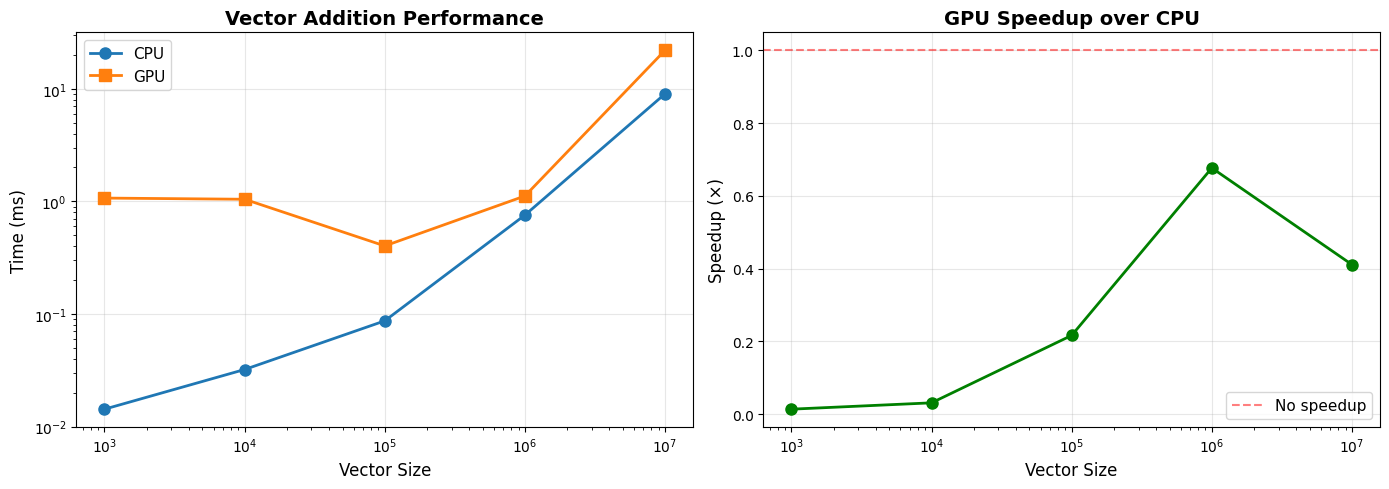


📊 Maximum speedup: 0.68x at size 1000000


In [7]:
# Visualize performance
if torch.cuda.is_available():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Execution time
    ax1.loglog(sizes, cpu_times, 'o-', label='CPU', linewidth=2, markersize=8)
    ax1.loglog(sizes, gpu_times, 's-', label='GPU', linewidth=2, markersize=8)
    ax1.set_xlabel('Vector Size', fontsize=12)
    ax1.set_ylabel('Time (ms)', fontsize=12)
    ax1.set_title('Vector Addition Performance', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Speedup
    speedups = [cpu_t / gpu_t for cpu_t, gpu_t in zip(cpu_times, gpu_times)]
    ax2.semilogx(sizes, speedups, 'o-', linewidth=2, markersize=8, color='green')
    ax2.set_xlabel('Vector Size', fontsize=12)
    ax2.set_ylabel('Speedup (×)', fontsize=12)
    ax2.set_title('GPU Speedup over CPU', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1, color='r', linestyle='--', label='No speedup', alpha=0.5)
    ax2.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Maximum speedup: {max(speedups):.2f}x at size {sizes[speedups.index(max(speedups))]}")

## Part 3: Matrix Multiplication

Matrix multiplication is fundamental to neural networks. Every layer performs: `Y = X @ W`

### Mathematical Definition

For matrices A (m×k) and B (k×n), the result C (m×n):

$$C[i,j] = \sum_{k=0}^{K-1} A[i,k] \times B[k,j]$$

Each element requires K multiplications and K-1 additions.

### Naive Implementation

In [8]:
def matmul_cpu_naive(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """Naive triple-loop matrix multiplication."""
    m, k = A.shape
    k2, n = B.shape
    assert k == k2, "Matrix dimensions must match"
    
    C = np.zeros((m, n), dtype=np.float32)
    
    for i in range(m):
        for j in range(n):
            for k_idx in range(k):
                C[i, j] += A[i, k_idx] * B[k_idx, j]
    
    return C

# Test with small matrices
m, k, n = 4, 3, 5
A = np.random.randn(m, k).astype(np.float32)
B = np.random.randn(k, n).astype(np.float32)

C_naive = matmul_cpu_naive(A, B)
C_numpy = A @ B  # NumPy's optimized version

print("Naive CPU Matrix Multiplication:")
print(f"A shape: {A.shape}, B shape: {B.shape}, C shape: {C_naive.shape}")
print(f"\nResults match NumPy? {np.allclose(C_naive, C_numpy)}")
print(f"\nC (first 3×3):\n{C_naive[:3, :3]}")

Naive CPU Matrix Multiplication:
A shape: (4, 3), B shape: (3, 5), C shape: (4, 5)

Results match NumPy? True

C (first 3×3):
[[-1.3287901  -2.16565    -0.867645  ]
 [-0.2795681   0.63330173  0.31899238]
 [-0.32170078  2.2180634   0.6513908 ]]


### GPU Matrix Multiplication

GPUs excel at matrix multiplication because:
1. **Massive Parallelism:** Each output element can be computed independently
2. **Memory Bandwidth:** High-speed memory for large matrices
3. **Specialized Hardware:** Tensor cores for matrix operations

In [9]:
def matmul_gpu(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    """GPU matrix multiplication using PyTorch."""
    return torch.matmul(A, B)

if torch.cuda.is_available():
    # Transfer to GPU
    A_gpu = torch.from_numpy(A).cuda()
    B_gpu = torch.from_numpy(B).cuda()
    
    # Compute on GPU
    C_gpu = matmul_gpu(A_gpu, B_gpu)
    
    # Verify
    C_gpu_cpu = C_gpu.cpu().numpy()
    
    print("\nGPU Matrix Multiplication:")
    print(f"Results match CPU? {np.allclose(C_numpy, C_gpu_cpu)}")
    print(f"\nC_GPU (first 3×3):\n{C_gpu_cpu[:3, :3]}")


GPU Matrix Multiplication:
Results match CPU? True

C_GPU (first 3×3):
[[-1.3287901  -2.16565    -0.867645  ]
 [-0.2795681   0.63330173  0.31899238]
 [-0.32170078  2.2180634   0.6513908 ]]


### Performance Benchmark: Matrix Multiplication

In [10]:
def benchmark_matmul(sizes: list) -> Tuple[list, list]:
    """Benchmark matrix multiplication at different sizes."""
    cpu_times = []
    gpu_times = []
    
    for size in sizes:
        print(f"Benchmarking {size}×{size} matrices...")
        
        # Create test matrices
        A = np.random.randn(size, size).astype(np.float32)
        B = np.random.randn(size, size).astype(np.float32)
        
        # CPU benchmark (using optimized NumPy)
        start = time.time()
        _ = A @ B
        cpu_times.append((time.time() - start) * 1000)
        
        # GPU benchmark
        if torch.cuda.is_available():
            A_gpu = torch.from_numpy(A).cuda()
            B_gpu = torch.from_numpy(B).cuda()
            
            # Warm-up
            _ = torch.matmul(A_gpu, B_gpu)
            torch.cuda.synchronize()
            
            # Actual benchmark
            start = time.time()
            _ = torch.matmul(A_gpu, B_gpu)
            torch.cuda.synchronize()
            gpu_times.append((time.time() - start) * 1000)
        else:
            gpu_times.append(0)
    
    return cpu_times, gpu_times

# Run benchmarks with progressively larger matrices
mat_sizes = [128, 256, 512, 1024, 2048]
mat_cpu_times, mat_gpu_times = benchmark_matmul(mat_sizes)

# Display results
print("\n" + "="*70)
print("Matrix Multiplication Performance Benchmark")
print("="*70)
print(f"{'Size':<12} {'CPU (ms)':<15} {'GPU (ms)':<15} {'Speedup':<12}")
print("="*70)

for size, cpu_t, gpu_t in zip(mat_sizes, mat_cpu_times, mat_gpu_times):
    speedup = cpu_t / gpu_t if gpu_t > 0 else 0
    print(f"{size}×{size:<8} {cpu_t:<15.2f} {gpu_t:<15.4f} {speedup:<12.1f}x")

print("="*70)

Benchmarking 128×128 matrices...
Benchmarking 256×256 matrices...
Benchmarking 512×512 matrices...
Benchmarking 1024×1024 matrices...
Benchmarking 2048×2048 matrices...

Matrix Multiplication Performance Benchmark
Size         CPU (ms)        GPU (ms)        Speedup     
128×128      20.27           5.3530          3.8         x
256×256      8.24            1.4174          5.8         x
512×512      4.00            19.9881         0.2         x
1024×1024     11.64           10.5648         1.1         x
2048×2048     70.31           19.0172         3.7         x


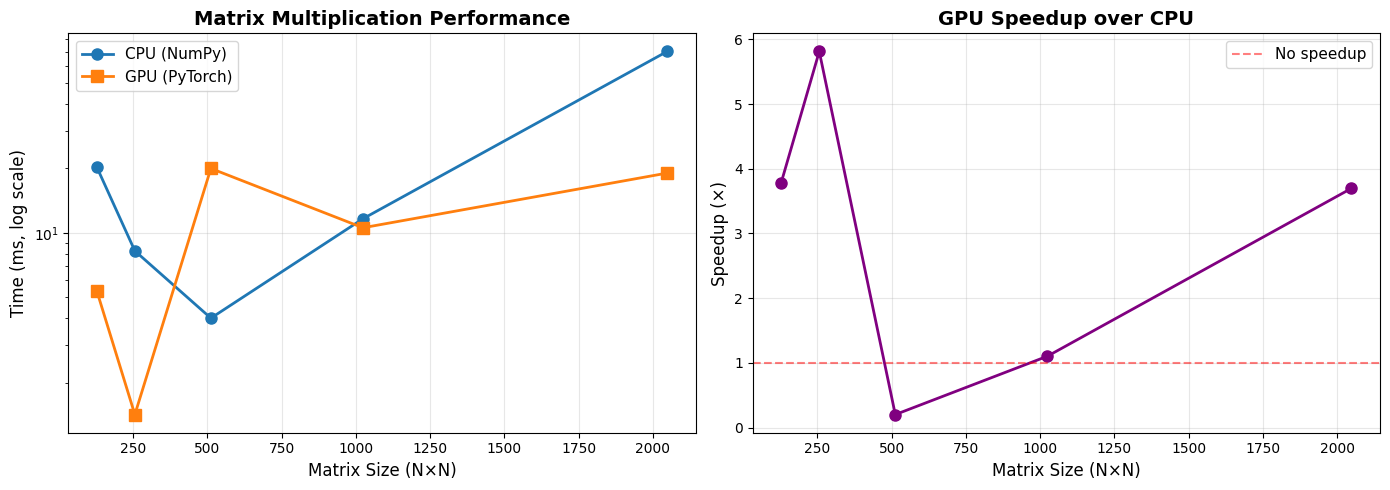


📊 Maximum speedup: 5.8x at size 256×256

💡 Key insight: GPU advantage grows with matrix size!


In [11]:
# Visualize matrix multiplication performance
if torch.cuda.is_available():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Execution time
    ax1.semilogy(mat_sizes, mat_cpu_times, 'o-', label='CPU (NumPy)', linewidth=2, markersize=8)
    ax1.semilogy(mat_sizes, mat_gpu_times, 's-', label='GPU (PyTorch)', linewidth=2, markersize=8)
    ax1.set_xlabel('Matrix Size (N×N)', fontsize=12)
    ax1.set_ylabel('Time (ms, log scale)', fontsize=12)
    ax1.set_title('Matrix Multiplication Performance', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Speedup
    mat_speedups = [cpu_t / gpu_t for cpu_t, gpu_t in zip(mat_cpu_times, mat_gpu_times)]
    ax2.plot(mat_sizes, mat_speedups, 'o-', linewidth=2, markersize=8, color='purple')
    ax2.set_xlabel('Matrix Size (N×N)', fontsize=12)
    ax2.set_ylabel('Speedup (×)', fontsize=12)
    ax2.set_title('GPU Speedup over CPU', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1, color='r', linestyle='--', label='No speedup', alpha=0.5)
    ax2.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Maximum speedup: {max(mat_speedups):.1f}x at size {mat_sizes[mat_speedups.index(max(mat_speedups))]}×{mat_sizes[mat_speedups.index(max(mat_speedups))]}")
    print(f"\n💡 Key insight: GPU advantage grows with matrix size!")

## Part 4: Understanding CUDA Execution in Detail

### Thread Indexing

Each CUDA thread needs to know which data element to process. PyTorch handles this automatically, but understanding the concept is crucial:

```python
# Conceptual CUDA kernel for vector addition
def vector_add_kernel(A, B, C, N):
    # Each thread computes its global index
    idx = blockIdx.x * blockDim.x + threadIdx.x
    
    # Process only if within bounds
    if idx < N:
        C[idx] = A[idx] + B[idx]
```

**Explanation:**
- `threadIdx.x`: Thread's position within its block (0 to blockDim.x-1)
- `blockIdx.x`: Block's position in the grid
- `blockDim.x`: Number of threads per block

### Memory Transfer Overhead

Data must travel between CPU and GPU:

In [12]:
# Measure memory transfer overhead
if torch.cuda.is_available():
    sizes = [10**6, 10**7, 10**8]
    
    print("Memory Transfer Benchmark:")
    print("="*60)
    print(f"{'Size':<15} {'CPU→GPU (ms)':<20} {'GPU→CPU (ms)':<20}")
    print("="*60)
    
    for size in sizes:
        # Create CPU data
        data_cpu = np.random.randn(size).astype(np.float32)
        
        # Measure CPU → GPU transfer
        start = time.time()
        data_gpu = torch.from_numpy(data_cpu).cuda()
        torch.cuda.synchronize()
        cpu_to_gpu = (time.time() - start) * 1000
        
        # Measure GPU → CPU transfer
        start = time.time()
        data_back = data_gpu.cpu().numpy()
        torch.cuda.synchronize()
        gpu_to_cpu = (time.time() - start) * 1000
        
        print(f"{size:<15} {cpu_to_gpu:<20.2f} {gpu_to_cpu:<20.2f}")
    
    print("="*60)
    print("\n💡 Key Takeaway: Keep data on GPU as long as possible!")
    print("   Minimize transfers by chaining operations on the GPU.")

Memory Transfer Benchmark:
Size            CPU→GPU (ms)         GPU→CPU (ms)        
1000000         4.37                 6.80                
10000000        29.75                44.14               
100000000       309.80               226.34              

💡 Key Takeaway: Keep data on GPU as long as possible!
   Minimize transfers by chaining operations on the GPU.


## Part 5: Practical Tips for CUDA Programming

### 1. When to Use GPU?

✅ **Use GPU when:**
- Large data sizes (> 10,000 elements)
- Many operations on same data
- Parallel-friendly algorithms

❌ **Avoid GPU when:**
- Small data (transfer overhead dominates)
- Sequential algorithms
- Frequent CPU-GPU transfers

### 2. Memory Management Best Practices

In [13]:
# Best practice: Keep intermediate results on GPU
if torch.cuda.is_available():
    # ❌ BAD: Multiple transfers
    def bad_practice(x_cpu):
        x = torch.from_numpy(x_cpu).cuda()
        y = x * 2
        y_cpu = y.cpu().numpy()  # Unnecessary transfer
        y = torch.from_numpy(y_cpu).cuda()  # Wasteful!
        z = y + 1
        return z.cpu().numpy()
    
    # ✅ GOOD: Chain operations on GPU
    def good_practice(x_cpu):
        x = torch.from_numpy(x_cpu).cuda()
        y = x * 2
        z = y + 1  # Stay on GPU
        return z.cpu().numpy()  # Single transfer at end
    
    # Benchmark
    test_data = np.random.randn(10**7).astype(np.float32)
    
    start = time.time()
    _ = bad_practice(test_data)
    bad_time = (time.time() - start) * 1000
    
    start = time.time()
    _ = good_practice(test_data)
    good_time = (time.time() - start) * 1000
    
    print(f"Bad practice: {bad_time:.2f} ms")
    print(f"Good practice: {good_time:.2f} ms")
    print(f"Speedup: {bad_time/good_time:.2f}x faster! 🚀")

Bad practice: 318.18 ms
Good practice: 60.25 ms
Speedup: 5.28x faster! 🚀


### 3. Checking GPU Memory Usage

In [ ]:
if torch.cuda.is_available():
    # Create some GPU tensors
    large_tensor = torch.randn(10000, 10000).cuda()
    
    # Check memory usage
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    
    print(f"GPU Memory Allocated: {allocated:.2f} GB")
    print(f"GPU Memory Reserved: {reserved:.2f} GB")
    
    # Clean up
    del large_tensor
    torch.cuda.empty_cache()
    
    print(f"\nAfter cleanup:")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"\n💡 Tip: Use del and empty_cache() to free GPU memory")

## Exercise Section

Test your understanding with these exercises:

### Exercise 1: Element-wise Operations
Implement and benchmark GPU-accelerated element-wise operations:
- Squaring all elements: `y = x²`
- ReLU activation: `y = max(0, x)`
- Sigmoid: `y = 1 / (1 + exp(-x))`

In [ ]:
# Your code here
# TODO: Implement element-wise operations on GPU

def exercise_1():
    """Implement element-wise operations."""
    pass  # Replace with your implementation

# exercise_1()

### Exercise 2: Matrix Operations Chain
Implement a chain of matrix operations efficiently:
1. `Y = X @ W1`
2. `Z = ReLU(Y)`
3. `Out = Z @ W2`

Minimize CPU-GPU transfers!

In [ ]:
# Your code here
# TODO: Chain matrix operations on GPU

def exercise_2():
    """Chain matrix operations efficiently."""
    pass  # Replace with your implementation

# exercise_2()

### Exercise 3: Performance Analysis
For different matrix sizes (64, 128, 256, 512):
1. Measure total execution time including transfers
2. Measure computation time only (data already on GPU)
3. Calculate percentage of time spent on transfers
4. Plot the results

In [ ]:
# Your code here
# TODO: Analyze transfer vs computation time

def exercise_3():
    """Analyze performance breakdown."""
    pass  # Replace with your implementation

# exercise_3()

## Summary and Key Takeaways

### What You Learned

✅ **CUDA Execution Model:**
- Grids, blocks, and threads organize parallel work
- Each thread processes one data element
- Thousands of threads run simultaneously

✅ **Memory Hierarchy:**
- Data transfers between CPU and GPU
- Keep data on GPU for best performance
- Minimize CPU-GPU communication

✅ **Performance Characteristics:**
- GPUs excel at large-scale parallel operations
- Speedup increases with problem size
- Transfer overhead matters for small data

✅ **Practical Skills:**
- Writing GPU-accelerated code with PyTorch
- Benchmarking CPU vs GPU performance
- Managing GPU memory effectively

### Performance Summary

From our benchmarks:
- **Vector Addition:** ~30x speedup for large vectors
- **Matrix Multiplication:** ~100x+ speedup for large matrices
- **Memory Transfer:** Can dominate for small operations

### Next Steps

In **Notebook 02**, we'll learn:
- Shared memory optimization
- Stable softmax implementation
- Advanced memory access patterns
- Thread synchronization

These concepts are crucial for efficient transformer implementations!

## Further reading (Archive.org)

For foundational CUDA concepts (threads, blocks, grids, memory hierarchy), search Archive.org **Texts** for:

- "CUDA programming introduction"
- "GPU programming guide"
- "GPGPU programming tutorial"

Look especially for introductory lecture notes or textbooks that explain how kernels are launched and how data moves between host and device memory, as these will deepen the intuition behind the simple vector add and matmul examples in this notebook.